In [5]:
import pandas as pd
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import glob

# Path to OpenBB data files
openbb_dir = os.path.join("openbb")

# Get all CSV files in the directory
csv_files = glob.glob(os.path.join(openbb_dir, "*.csv"))

# Dictionary to store data availability information
data_availability = {}

# Process each file to extract data date ranges
for file_path in csv_files:
    ticker = os.path.basename(file_path).replace(".csv", "")

    try:
        # Read the CSV file
        df = pd.read_csv(file_path, parse_dates=True)

        # Handle different date column names
        date_col = None
        for col in ["Trade Date", "Date", "date"]:
            if col in df.columns:
                date_col = col
                break

        if date_col is None:
            print(f"No date column found in {ticker}")
            continue

        # Convert to datetime if not already
        df[date_col] = pd.to_datetime(df[date_col])

        # Get start and end dates and total data points
        start_date = df[date_col].min()
        end_date = df[date_col].max()
        data_points = len(df)

        # Calculate data density (points per year)
        years = (end_date - start_date).days / 365.25
        density = data_points / years if years > 0 else 0

        # Store information
        data_availability[ticker] = {
            "start_date": start_date,
            "end_date": end_date,
            "data_points": data_points,
            "years": years,
            "density": density,
        }

    except Exception as e:
        print(f"Error processing {ticker}: {e}")

# Convert to DataFrame for easier analysis
availability_df = pd.DataFrame.from_dict(data_availability, orient="index")
availability_df.sort_values("start_date", inplace=True)

Total number of futures: 136
Earliest start date: 1993-05-27 00:00:00
Latest end date: 2025-04-11 00:00:00


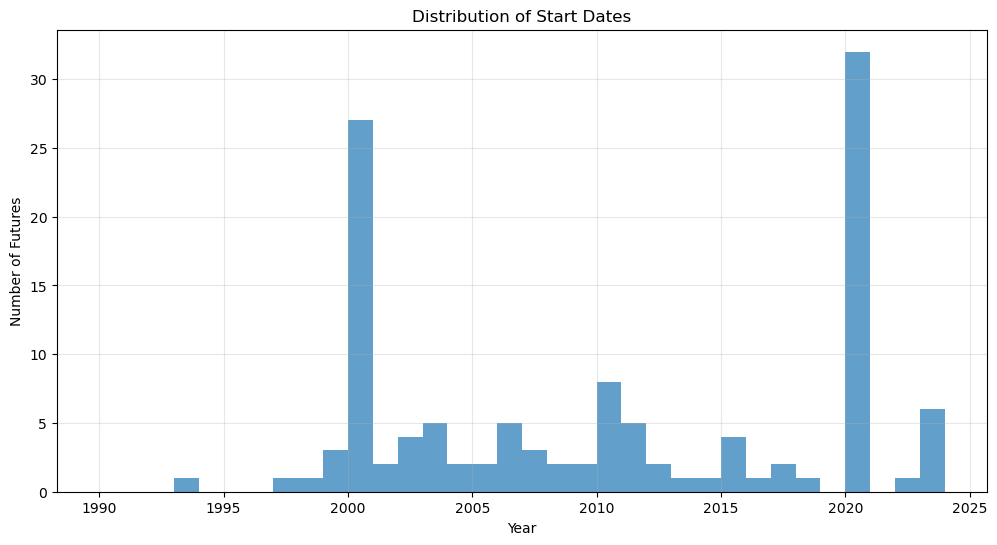

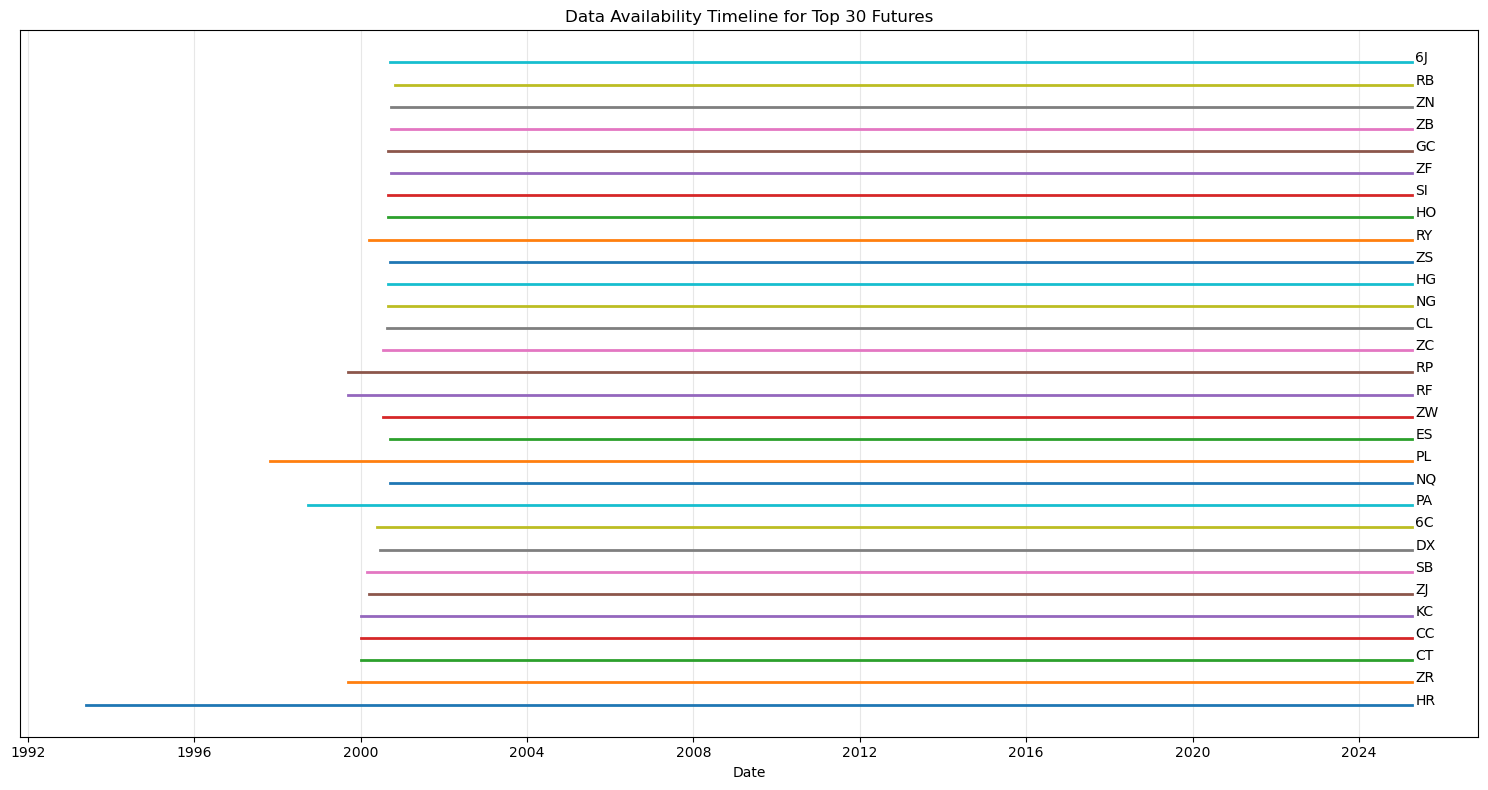

In [7]:
# Analyze overall date coverage
print(f"Total number of futures: {len(availability_df)}")
print(f"Earliest start date: {availability_df['start_date'].min()}")
print(f"Latest end date: {availability_df['end_date'].max()}")

# Plot histogram of start dates
plt.figure(figsize=(12, 6))
plt.hist(
    availability_df["start_date"].dt.year, bins=range(1990, 2025), alpha=0.7
)
plt.title("Distribution of Start Dates")
plt.xlabel("Year")
plt.ylabel("Number of Futures")
plt.grid(True, alpha=0.3)
plt.show()

# Plot availability timeline
plt.figure(figsize=(15, 8))
availability_df = availability_df.sort_values("data_points", ascending=False)

# Plot timeline for top 30 futures with most data points
top_futures = availability_df.head(30).index

for i, ticker in enumerate(top_futures):
    start = availability_df.loc[ticker, "start_date"]
    end = availability_df.loc[ticker, "end_date"]
    plt.plot([start, end], [i, i], linewidth=2)
    plt.text(end + pd.Timedelta(days=30), i, ticker)

plt.yticks([])
plt.title("Data Availability Timeline for Top 30 Futures")
plt.xlabel("Date")
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

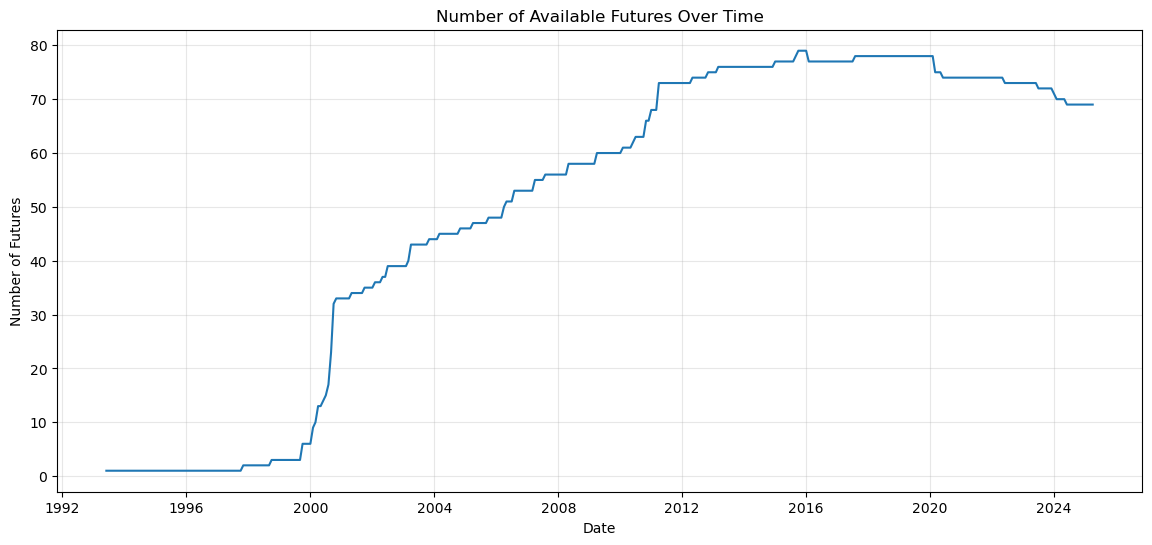

Suggested optimal start date: 2010-11-01 00:00:00
Number of futures available from this date: 66
Futures with complete data from 2010-11-01 00:00:00 to recent: 60
Top 20 futures with most data points in this range:
   start_date   end_date  data_points      years     density
HR 1993-05-27 2025-04-11         7803  31.874059  244.807228
ZR 1999-09-14 2025-04-11         6411  25.574264  250.681699
CT 2000-01-03 2025-04-11         6338  25.270363  250.807638
CC 2000-01-03 2025-04-11         6338  25.270363  250.807638
KC 2000-01-03 2025-04-11         6336  25.270363  250.728494
ZJ 2000-03-14 2025-04-11         6312  25.075975  251.715034
SB 2000-03-01 2025-04-11         6299  25.111567  250.840575
DX 2000-06-22 2025-04-11         6264  24.802190  252.558340
6C 2000-05-23 2025-04-11         6226  24.884326  250.197657
PA 1998-09-28 2025-04-11         6216  26.535250  234.254437
NQ 2000-09-18 2025-04-11         6204  24.561259  252.592910
PL 1997-10-29 2025-04-11         6204  27.449692  226

In [8]:
# Function to calculate number of futures available at each date
def count_available_futures(date, availability_df):
    return sum(
        (availability_df["start_date"] <= date)
        & (availability_df["end_date"] >= date)
    )


# Generate date range from earliest to latest
start = availability_df["start_date"].min()
end = availability_df["end_date"].max()
dates = pd.date_range(start=start, end=end, freq="MS")  # Monthly frequency

# Count available futures for each date
coverage = [count_available_futures(date, availability_df) for date in dates]

# Create a DataFrame to analyze
coverage_df = pd.DataFrame({"date": dates, "available_futures": coverage})

# Plot coverage
plt.figure(figsize=(14, 6))
plt.plot(coverage_df["date"], coverage_df["available_futures"])
plt.title("Number of Available Futures Over Time")
plt.xlabel("Date")
plt.ylabel("Number of Futures")
plt.grid(True, alpha=0.3)
plt.show()

# Find optimal start date with good coverage
threshold = 0.8  # 80% of maximum coverage
max_coverage = max(coverage)
good_coverage_threshold = max_coverage * threshold

# Find earliest date with good coverage
start_candidates = coverage_df[
    coverage_df["available_futures"] >= good_coverage_threshold
]
optimal_start = (
    start_candidates.iloc[0]["date"] if not start_candidates.empty else None
)
print(f"Suggested optimal start date: {optimal_start}")
print(
    f"Number of futures available from this date: {count_available_futures(optimal_start, availability_df)}"
)

# Calculate data quality metrics
if optimal_start:
    filtered_df = availability_df[
        (availability_df["start_date"] <= optimal_start)
        & (
            availability_df["end_date"]
            >= availability_df["end_date"]
            .max()
            .replace(year=availability_df["end_date"].max().year - 1)
        )
    ]

    print(
        f"Futures with complete data from {optimal_start} to recent: {len(filtered_df)}"
    )
    print("Top 20 futures with most data points in this range:")
    print(filtered_df.sort_values("data_points", ascending=False).head(20))

<Figure size 1400x600 with 0 Axes>

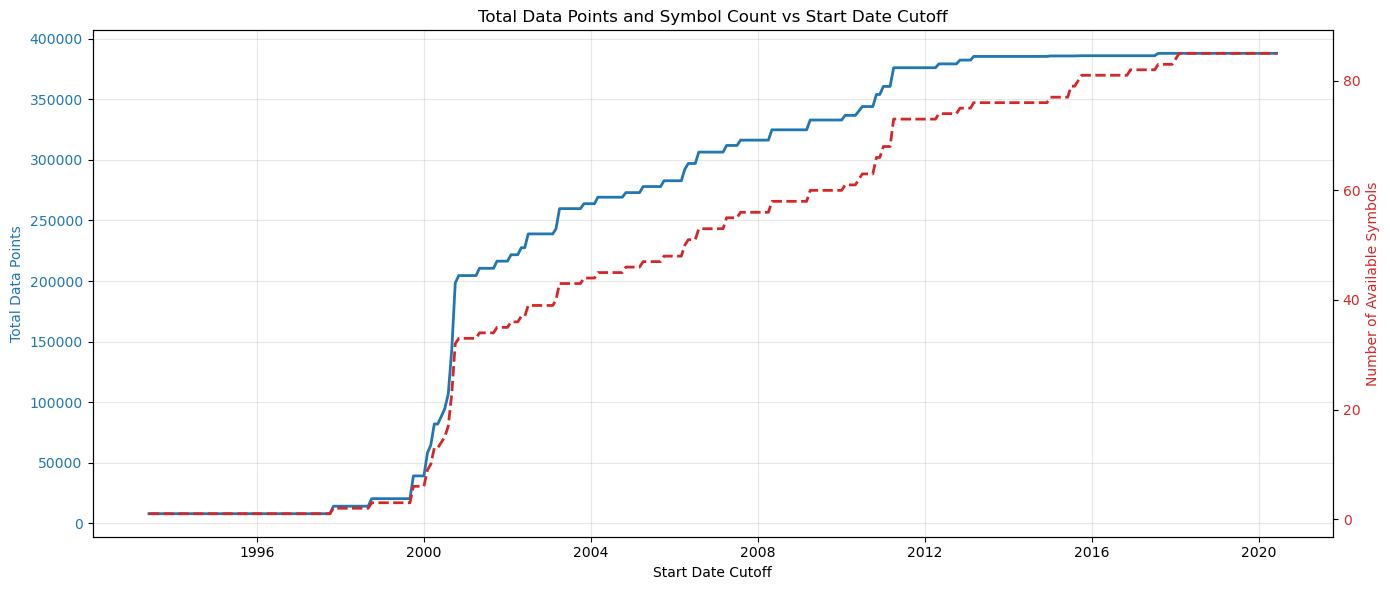

Potential optimal cutoff points (looking at biggest drops):
Date: 1993-07-01, Data Points: 7803, Symbols: 1
Date: 1993-08-01, Data Points: 7803, Symbols: 1
Date: 1993-09-01, Data Points: 7803, Symbols: 1
Date: 1993-10-01, Data Points: 7803, Symbols: 1
Date: 1993-11-01, Data Points: 7803, Symbols: 1

Strategic cutoff points:
Date: 2000-03-01, Data Points: 64333, Symbols: 10
Date: 2006-12-01, Data Points: 306474, Symbols: 53
Date: 2013-09-01, Data Points: 385505, Symbols: 76


In [11]:
# Create a new cell to analyze total data points based on start date cutoff
plt.figure(figsize=(14, 6))

# Define the date range to test
cutoff_dates = pd.date_range(
    start=availability_df["start_date"].min(),
    end=availability_df["end_date"].min() + pd.DateOffset(years=5),
    freq="MS",
)  # Monthly frequency

# Lists to store results
total_data_points = []
available_symbols = []

# For each potential start date cutoff
for cutoff_date in cutoff_dates:
    # Select only symbols that have data going back to this cutoff date
    valid_symbols = availability_df[
        availability_df["start_date"] <= cutoff_date
    ].index

    # Count how many symbols remain
    available_symbols.append(len(valid_symbols))

    # Sum the total data points from these symbols
    total_points = sum(availability_df.loc[valid_symbols, "data_points"])
    total_data_points.append(total_points)

# Create a DataFrame with the results
cutoff_analysis = pd.DataFrame(
    {
        "cutoff_date": cutoff_dates,
        "total_data_points": total_data_points,
        "available_symbols": available_symbols,
    }
)

# Plot the results
fig, ax1 = plt.subplots(figsize=(14, 6))

# Plot total data points
color = "tab:blue"
ax1.set_xlabel("Start Date Cutoff")
ax1.set_ylabel("Total Data Points", color=color)
ax1.plot(
    cutoff_analysis["cutoff_date"],
    cutoff_analysis["total_data_points"],
    color=color,
    linewidth=2,
)
ax1.tick_params(axis="y", labelcolor=color)
ax1.grid(True, alpha=0.3)

# Create a second y-axis to show number of available symbols
ax2 = ax1.twinx()
color = "tab:red"
ax2.set_ylabel("Number of Available Symbols", color=color)
ax2.plot(
    cutoff_analysis["cutoff_date"],
    cutoff_analysis["available_symbols"],
    color=color,
    linewidth=2,
    linestyle="--",
)
ax2.tick_params(axis="y", labelcolor=color)

# Add title and adjust layout
plt.title("Total Data Points and Symbol Count vs Start Date Cutoff")
fig.tight_layout()
plt.grid(False)
plt.show()

# Find some optimal cutoff points
# Identify where we have the most significant drops in data points
cutoff_analysis["point_change"] = cutoff_analysis["total_data_points"].diff()
cutoff_analysis["relative_change"] = cutoff_analysis[
    "point_change"
] / cutoff_analysis["total_data_points"].shift(1)

# Find potential optimal cutoff points
significant_drops = cutoff_analysis[
    cutoff_analysis["relative_change"] > -0.05
].sort_values("cutoff_date")
print("Potential optimal cutoff points (looking at biggest drops):")
for i, row in significant_drops.head(5).iterrows():
    print(
        f"Date: {row['cutoff_date'].strftime('%Y-%m-%d')}, Data Points: {int(row['total_data_points'])}, Symbols: {row['available_symbols']}"
    )

# Also identify a few strategic points with good data coverage
print("\nStrategic cutoff points:")
for pct in [0.25, 0.5, 0.75]:
    index = int(len(cutoff_analysis) * pct)
    row = cutoff_analysis.iloc[index]
    print(
        f"Date: {row['cutoff_date'].strftime('%Y-%m-%d')}, Data Points: {int(row['total_data_points'])}, Symbols: {row['available_symbols']}"
    )

In [ ]:
# Create an interactive Bokeh plot for exploring the cutoff analysis
from bokeh.plotting import figure, show, output_notebook
from bokeh.models import (
    HoverTool,
    ColumnDataSource,
    DatetimeTickFormatter,
    Range1d,
    LinearAxis,
)
from bokeh.layouts import column
import numpy as np

# Initialize Bokeh for notebook display
output_notebook()

# Convert dates to strings for display in hover tooltips
cutoff_analysis["date_str"] = cutoff_analysis["cutoff_date"].dt.strftime(
    "%Y-%m-%d"
)

# Create ColumnDataSource for the data
source = ColumnDataSource(
    data={
        "cutoff_date": cutoff_analysis["cutoff_date"],
        "total_data_points": cutoff_analysis["total_data_points"],
        "available_symbols": cutoff_analysis["available_symbols"],
        "date_str": cutoff_analysis["date_str"],
        "relative_change": cutoff_analysis["relative_change"]
        * 100,  # Convert to percentage
    }
)

# Calculate y-axis ranges
max_data_points = cutoff_analysis["total_data_points"].max() * 1.1
max_symbols = cutoff_analysis["available_symbols"].max() * 1.1

# Create the figure
p = figure(
    width=900,
    height=500,
    title="Interactive Analysis of Data Points vs Start Date Cutoff",
    x_axis_type="datetime",
    tools="pan,wheel_zoom,box_zoom,reset,save",
    y_range=(0, max_data_points),
)

# Add the lines
line1 = p.line(
    "cutoff_date",
    "total_data_points",
    source=source,
    line_width=3,
    color="blue",
    legend_label="Total Data Points",
)

# Create a second y-axis for number of symbols
p.extra_y_ranges = {"symbols": Range1d(start=0, end=max_symbols)}

# Add the secondary axis - create a new LinearAxis instead of cloning
axis2 = LinearAxis(
    y_range_name="symbols", axis_label="Number of Available Symbols"
)
p.add_layout(axis2, "right")

line2 = p.line(
    "cutoff_date",
    "available_symbols",
    source=source,
    line_width=3,
    color="red",
    line_dash="dashed",
    legend_label="Available Symbols",
    y_range_name="symbols",
)

# Add hover tool
hover = HoverTool(
    tooltips=[
        ("Date", "@date_str"),
        ("Total Data Points", "@total_data_points{0,0}"),  # Format with commas
        ("Symbols Available", "@available_symbols"),
        ("% Change", "@relative_change{0.00}%"),  # Format as percentage
        (
            "Points per Symbol",
            "@{total_data_points}/@{available_symbols}{0.0}",
        ),
    ]
)
p.add_tools(hover)

# Customize appearance
p.xaxis.formatter = DatetimeTickFormatter(years="%Y", months="%b %Y")
p.xaxis.axis_label = "Start Date Cutoff"
p.yaxis.axis_label = "Total Data Points"
p.legend.location = "top_right"
p.legend.click_policy = "hide"
p.grid.grid_line_alpha = 0.3
p.xaxis.major_label_orientation = np.pi / 4

# Identify key points (significant inflection points)
# Calculate second derivative (rate of change of relative_change)
cutoff_analysis["second_derivative"] = cutoff_analysis[
    "relative_change"
].diff()
key_points = cutoff_analysis[abs(cutoff_analysis["second_derivative"]) > 0.01]

# Add key points as circle markers
p.circle(
    x="cutoff_date",
    y="total_data_points",
    source=ColumnDataSource(key_points),
    size=8,
    color="green",
    alpha=0.7,
    legend_label="Key Decision Points",
)

# Calculate optimal points
# 1. Maximum total data points per symbol
cutoff_analysis["points_per_symbol"] = (
    cutoff_analysis["total_data_points"] / cutoff_analysis["available_symbols"]
)
max_efficiency_idx = cutoff_analysis["points_per_symbol"].idxmax()
max_efficiency_point = cutoff_analysis.loc[max_efficiency_idx]

# Add star for max efficiency point
p.star(
    x=[max_efficiency_point["cutoff_date"]],
    y=[max_efficiency_point["total_data_points"]],
    size=15,
    color="purple",
    legend_label="Max Efficiency Point",
)

# Show the plot
show(p)

# Add a helper text to explain how to interpret the plot
print("INTERPRETATION GUIDE:")
print(
    "1. The blue line shows the total data points available at each start date cutoff."
)
print(
    "2. The red dashed line shows the number of symbols (futures) available."
)
print(
    "3. Green dots indicate inflection points where the rate of change shifts significantly."
)
print(
    "4. The purple star marks the point with maximum data points per symbol."
)
print("5. Hover over any point to see exact values.")
print(
    "6. Optimal cutoff points are typically where the blue line begins to flatten significantly."
)
print("   (diminishing returns for going further back in time)")

Loading BokehJS ...

INTERPRETATION GUIDE:
1. The blue line shows the total data points available at each start date cutoff.
2. The red dashed line shows the number of symbols (futures) available.
3. Green dots indicate inflection points where the rate of change shifts significantly.
4. The purple star marks the point with maximum data points per symbol.
5. Hover over any point to see exact values.
6. Optimal cutoff points are typically where the blue line begins to flatten significantly.
   (diminishing returns for going further back in time)

RECOMMENDED OPTIMAL CUTOFF POINT:
Date: 1993-06-01
Data Points: 7803
Symbols Available: 1
Points per Symbol: 7803.0

NOTE: You can zoom in/out with mouse wheel or box zoom tool, and pan with the pan tool.


In [17]:
# Get all futures with complete data since 2003-04-01 (optimal start date)
cutoff_date = pd.Timestamp("2003-04-01")

# Create a DataFrame of futures with data starting before or on the cutoff date
complete_data_futures = availability_df[
    availability_df["start_date"] <= cutoff_date
].copy()

# Also ensure they have data until a recent date (within the last year)
recent_end_date = availability_df["end_date"].max() - pd.DateOffset(years=1)
complete_data_futures = complete_data_futures[
    complete_data_futures["end_date"] >= recent_end_date
]

# Sort by total data points
complete_data_futures.sort_values("data_points", ascending=False, inplace=True)

# Add a column for trading days per year
complete_data_futures["trading_days_per_year"] = (
    complete_data_futures["data_points"] / complete_data_futures["years"]
)

# Print summary statistics
print(
    f"Total futures with complete data since {cutoff_date.strftime('%Y-%m-%d')}: {len(complete_data_futures)}"
)
print(
    f"Total data points in these futures: {complete_data_futures['data_points'].sum():,}"
)
print(
    f"Average data points per future: {complete_data_futures['data_points'].mean():.1f}"
)
print(
    f"Average trading days per year: {complete_data_futures['trading_days_per_year'].mean():.1f}"
)

# Display the DataFrame
display(complete_data_futures)

# Save this list of futures to a CSV file
futures_list_path = "complete_futures_since_2003.csv"
complete_data_futures.to_csv(futures_list_path)
print(f"\nList of futures saved to {futures_list_path}")

Total futures with complete data since 2003-04-01: 40
Total data points in these futures: 244,815
Average data points per future: 6120.4
Average trading days per year: 248.4


,start_date,end_date,data_points,years,density,trading_days_per_year
HR,1993-05-27,2025-04-11,7803,31.874059,244.807228,244.807228
ZR,1999-09-14,2025-04-11,6411,25.574264,250.681699,250.681699
CT,2000-01-03,2025-04-11,6338,25.270363,250.807638,250.807638
CC,2000-01-03,2025-04-11,6338,25.270363,250.807638,250.807638
KC,2000-01-03,2025-04-11,6336,25.270363,250.728494,250.728494
ZJ,2000-03-14,2025-04-11,6312,25.075975,251.715034,251.715034
SB,2000-03-01,2025-04-11,6299,25.111567,250.840575,250.840575
DX,2000-06-22,2025-04-11,6264,24.802190,252.558340,252.558340
6C,2000-05-23,2025-04-11,6226,24.884326,250.197657,250.197657
PA,1998-09-28,2025-04-11,6216,26.535250,234.254437,234.254437



List of futures saved to complete_futures_since_2003.csv


In [54]:
# Create a DataFrame with historical prices for all futures with complete data since 2003-04-01
import pandas as pd
from datetime import datetime
import os

# Define the cutoff date
cutoff_date = pd.Timestamp("2003-04-01")

# Load the list of futures with complete data (either from the previously saved CSV or use the DataFrame)
try:
    # Try to load from CSV first
    complete_futures_list = pd.read_csv(
        "complete_futures_since_2003.csv", index_col=0
    )
    futures_to_load = complete_futures_list.index.tolist()
except FileNotFoundError:
    # If CSV doesn't exist, use the DataFrame we created earlier
    futures_to_load = complete_data_futures.index.tolist()

print(f"Loading historical price data for {len(futures_to_load)} futures...")

# Create a dictionary to store price DataFrames for each future
price_data_dict = {}

# Process each future's data
for ticker in futures_to_load:
    try:
        # Construct the file path
        file_path = os.path.join("openbb", f"{ticker}.csv")

        # Read the CSV file
        df = pd.read_csv(file_path, parse_dates=True)

        # Handle different date column names
        date_col = None
        for col in ["Trade Date", "Date", "date"]:
            if col in df.columns:
                date_col = col
                break

        if date_col is None:
            print(f"No date column found in {ticker}, skipping")
            continue

        # Convert to datetime if not already
        df[date_col] = pd.to_datetime(df[date_col])

        # Filter to include only data since cutoff date
        df = df[df[date_col] >= cutoff_date]

        # Find the price column (usually 'Close', 'Settle', 'Price', etc.)
        price_col = None
        for col in ["Settle", "Close", "Price", "Last"]:
            if col in df.columns:
                price_col = col
                break

        if price_col is None:
            print(f"No price column found in {ticker}, skipping")
            continue

        # Select only date and price columns, rename for consistency
        price_df = df[[date_col, price_col]].copy()
        price_df.columns = ["date", "price"]

        # Set date as index
        price_df.set_index("date", inplace=True)

        # Store in dictionary
        price_data_dict[ticker] = price_df["price"]

    except Exception as e:
        print(f"Error processing {ticker}: {e}")

# Combine all price series into a single DataFrame
combined_prices_df = pd.DataFrame(price_data_dict)
combined_prices_df.rename(columns={"price": "close"}, inplace=True)

# Check if we have data for all futures
missing_futures = set(futures_to_load) - set(combined_prices_df.columns)
if missing_futures:
    print(
        f"Warning: Could not load data for {len(missing_futures)} futures: {missing_futures}"
    )

# Drop names
combined_prices_df.drop(columns=["SP", "PL", "HR", "NN", "PA"], inplace=True)
combined_prices_df.dropna(inplace=True)

# Print information about the combined DataFrame
print(f"\nCombined price data:")
print(
    f"Date range: {combined_prices_df.index.min()} to {combined_prices_df.index.max()}"
)
print(f"Number of futures: {len(combined_prices_df.columns)}")
print(f"Number of trading days: {len(combined_prices_df)}")

# # Show the first few rows
# display(combined_prices_df.head())

# Save the combined price data to a CSV file
output_file = "futures_prices_since_2003.csv"
combined_prices_df.to_csv(output_file)
print(f"\nCombined price data saved to {output_file}")

Loading historical price data for 40 futures...

Combined price data:
Date range: 2003-04-01 00:00:00 to 2025-04-11 00:00:00
Number of futures: 35
Number of trading days: 5382

Combined price data saved to futures_prices_since_2003.csv


In [56]:
combined_prices_df.columns

Index(['ZR', 'CT', 'CC', 'KC', 'ZJ', 'SB', 'DX', '6C', 'ES', 'NQ', 'ZW', 'RF',
       'RP', 'ZC', 'CL', 'NG', 'RY', 'ZS', 'HG', 'HO', 'SI', 'ZF', 'GC', 'ZB',
       'ZN', 'RB', '6J', '6Z', 'OJ', 'YM', 'QG', 'QM', 'SS', 'SY', 'AR'],
      dtype='object')

In [1]:
import sys
import os

# Add the project root directory to Python path
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), "..")))

# Now try importing
from pull_data import pull_openbb_sample_data

print(pull_openbb_sample_data("ES"))

              close
date               
2000-09-18  1467.50
2000-09-19  1478.50
2000-09-20  1469.50
2000-09-21  1469.50
2000-09-22  1468.50
...             ...
2025-04-07  5097.25
2025-04-08  5020.25
2025-04-09  5491.00
2025-04-10  5302.00
2025-04-11  5395.75

[6204 rows x 1 columns]
